In [4]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
%matplotlib inline

In [3]:
data_folder = "data/task9"

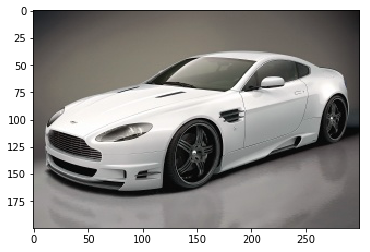

In [6]:
file = os.path.join(data_folder, '5.jpg')
img = cv2.imread(file)
plt.imshow(img)

In [14]:
class DSU:
    def __init__(self):
        self.parent = {}
        self.size = {}
        self.int = {}
    
    def add(self, obj):
        self.parent[obj] = obj
        self.size[obj] = 1
        self.int[obj] = 0
        
    def find(self, obj):
        if self.parent[obj] == obj:
            return obj
        self.parent[obj] = self.find(self.parent[obj])
        return self.parent[obj]
    
    def getSize(self, obj):
        return self.size[self.find(obj)]
    
    def getInt(self, obj):
        return self.int[self.find(obj)]
    
    def getRoots(self):
        roots = []
        for obj in self.parent:
            if self.parent[obj] == obj:
                roots.append(obj)
        return roots

    def unite(self, obj1, obj2, weight):
        root1 = self.find(obj1)
        root2 = self.find(obj2)
        if root1 != root2:
            if self.size[root1] > self.size[root2]:
                root1, root2 = root2, root1
            self.parent[root1] = root2
            self.size[root2] += self.size[root1]
            self.int[root2] = weight

In [118]:
def solve(img, f_dist, k=100):
    dsu = DSU()
    for y in range(img.shape[0]):
        for x in range(img.shape[1]):
            dsu.add((x, y))
    edges = []
    for y in range(img.shape[0]-1):
        for x in range(img.shape[1]-1):
            edges.append({'p1': (x, y), 'p2': (x+1, y), 'w': f_dist(img[y][x], img[y][x+1])})
            edges.append({'p1': (x, y), 'p2': (x, y+1), 'w': f_dist(img[y][x], img[y+1][x])})
            edges.append({'p1': (x, y), 'p2': (x+1, y+1), 'w': f_dist(img[y][x], img[y+1][x+1])})
    lastX = img.shape[1]-1
    for y in range(img.shape[0]-1):
        edges.append({'p1': (lastX, y), 'p2': (lastX, y+1), 'w': f_dist(img[y][lastX], img[y+1][lastX])})
    lastY = img.shape[0]-1
    for x in range(img.shape[1]-1):
        edges.append({'p1': (x, lastY), 'p2': (x+1, lastY), 'w': f_dist(img[lastY][x], img[lastY][x+1])})
    edges.sort(key=lambda e: e['w'])
    
    for e in edges:
        if dsu.find(e['p1']) == dsu.find(e['p2']):
            continue
        d1 = dsu.getInt(e['p1']) + k / dsu.getSize(e['p1'])
        d2 = dsu.getInt(e['p2']) + k / dsu.getSize(e['p2'])
        if e['w'] <= min(d1, d2):
            dsu.unite(e['p1'], e['p2'], e['w'])
            
    roots = dsu.getRoots()
    for root in roots:
        if dsu.getSize(root) < k * 0.5:
            best_neighbour = root
            best_dist = np.inf
            for y in range(img.shape[0]):
                for x in range(img.shape[1]):
                    if dsu.find((x, y)) == root:
                        for dy in range(-1, 2):
                            for dx in range(-1, 2):
                                nx = x+dx
                                ny = y+dy
                                if nx>=0 and ny>=0 and nx<img.shape[1] and ny<img.shape[0]:
                                    if dsu.find((nx, ny)) != root and f_dist(img[y][x], img[ny][nx])<best_dist \
                                    and dsu.getSize((nx, ny)) > dsu.getSize(root):
                                        best_dist = f_dist(img[y][x], img[ny][nx])
                                        best_neighbour = dsu.find((nx, ny))
            dsu.unite(root, best_neighbour, best_dist)
    
    colors = np.random.rand(len(roots), 3)
    seg_img = np.zeros(shape=(img.shape[0], img.shape[1], 3))
    for y in range(img.shape[0]):
        for x in range(img.shape[1]):
            root = dsu.find((x, y))
            seg_img[y][x] = colors[roots.index(root)]
    
    plt.imshow(seg_img)

In [46]:
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
plt.imshow(gray, cmap='gray')

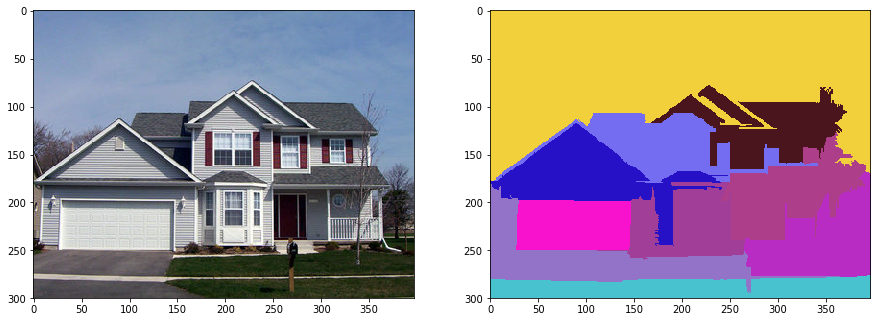

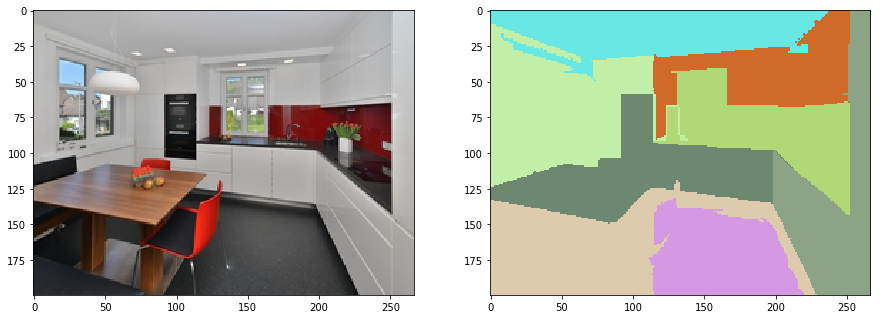

In [119]:
def gray_dist(col1, col2):
    return abs(int(col1) - int(col2))

for file in os.listdir(data_folder):
    img = cv2.cvtColor(cv2.imread(os.path.join(data_folder, file)), cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    plt.figure(figsize=(15, 10))
    plt.subplot(121)
    plt.imshow(img)
    plt.subplot(122)
    solve(gray, gray_dist, k=5000)
    plt.show()